In [6]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    !pip install torch, torchvision

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor

## CNN Details

The kernel/filter/weight matrix is a 5x5 matrix. Out channels corresponds to the number of created feature maps, and therefore impacts the number of kernels.

MaxPool2D is a 2x2 sliding window taking the maximum value in that window.

Since this is the MNIST dataset, each image is 28x28. If we take a batch size of 1, this means our structure is:

Input (28x28) **->**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2D (16x28x28) **->** ReLU (16x28x28) **->** MaxPool2D (16x14x14) **->**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2D (32x14x14) **->** RelU (32x14x14) **->** MaxPool2D (32x7x7) **->**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Flatten (1568x1) **->** FCN **->**
Returned Output (10x1)

In [8]:
#Derived from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

class ExampleCNN(nn.Module):
    def __init__(self):
        super(ExampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=2)
        self.activation = nn.ReLU()
        self.pool2d = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2)
        self.fcn = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.pool2d(self.activation(self.conv1(x)))
        x = self.pool2d(self.activation(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        
        out = self.fcn(x)
        return out

In [10]:
from torch.utils.data import DataLoader

"""
Running in COLAB assumes you've not imported the entire repository and simply saves the data with the notebook

Running in Jupyter Notebook assumes you have imported the entire repository and stores it in the data folder
"""
if RunningInCOLAB:
    train_data = torchvision.datasets.MNIST('.', train=True, transform=ToTensor(), download=True)
    test_data = torchvision.datasets.MNIST('.', train=False, transform=ToTensor(), download=True)
else:
    train_data = torchvision.datasets.MNIST('.', train=True, transform=ToTensor(), download=True)
    test_data = torchvision.datasets.MNIST('.', train=False, transform=ToTensor(), download=True)
batch_size = 124
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
loaders = {'train' : train_loader, 'test' : test_loader}

In [11]:
from torch.autograd import Variable
from torch import optim

cnn = ExampleCNN()


num_epochs = 10

loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   

def train(epochs, network, data_loaders):
    
    network.train()
        
    # Train the model
    total_step = len(data_loaders['train'])
        
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(x)   # batch x
            b_y = Variable(y)   # batch y
            b_y[b_y <= 4] = 0
            b_y[b_y > 4] = 1
            output = network(b_x)
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, epochs, i + 1, total_step, loss.item()))

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/484], Loss: 0.1208
Epoch [1/10], Step [200/484], Loss: 0.1904
Epoch [1/10], Step [300/484], Loss: 0.0673
Epoch [1/10], Step [400/484], Loss: 0.0677
Epoch [2/10], Step [100/484], Loss: 0.0251
Epoch [2/10], Step [200/484], Loss: 0.1076
Epoch [2/10], Step [300/484], Loss: 0.1294
Epoch [2/10], Step [400/484], Loss: 0.0634
Epoch [3/10], Step [100/484], Loss: 0.0132
Epoch [3/10], Step [200/484], Loss: 0.0771
Epoch [3/10], Step [300/484], Loss: 0.0373
Epoch [3/10], Step [400/484], Loss: 0.0477
Epoch [4/10], Step [100/484], Loss: 0.0536
Epoch [4/10], Step [200/484], Loss: 0.0499
Epoch [4/10], Step [300/484], Loss: 0.0119
Epoch [4/10], Step [400/484], Loss: 0.0398
Epoch [5/10], Step [100/484], Loss: 0.0262
Epoch [5/10], Step [200/484], Loss: 0.0727
Epoch [5/10], Step [300/484], Loss: 0.0447
Epoch [5/10], Step [400/484], Loss: 0.0081
Epoch [6/10], Step [100/484], Loss: 0.0146
Epoch [6/10], Step [200/484], Loss: 0.0571
Epoch [6/10], Step [300/484], Loss: 0.0233
Epoch [6/10

In [12]:
def test():
    # Test the model
    cnn.eval()    
    
    with torch.no_grad():
        for x, y in loaders['test']:
            y[y <= 4] = 0
            y[y > 4] = 1
            out = cnn(x)
            y_prediction = torch.max(out, 1)[1].data.squeeze()
            accuracy = (y_prediction == y).sum().item() / float(y.size(0))
            pass
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.99


In [23]:
sample = next(iter(loaders['test']))
images, labels = sample
actual_number = labels[:10].numpy()
actual_number[actual_number <= 4] = 0
actual_number[actual_number > 4] = 1
test_output = cnn(images[:10])
y_predictions = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {y_predictions}')
print(f'Actual number: {actual_number}')

Prediction number: [1 0 0 0 0 0 0 1 1 1]
Actual number: [1 0 0 0 0 0 0 1 1 1]


In [18]:
print(cnn.conv1.weight)

Parameter containing:
tensor([[[[ 1.1113e-01,  4.5225e-02, -2.6437e-01, -9.1305e-01, -5.3406e-01],
          [-1.2130e-01,  7.9213e-01,  2.8730e-01, -5.1500e-01, -3.0838e-01],
          [-8.7722e-01,  3.2245e-01,  6.3385e-01, -6.5821e-01, -1.1273e+00],
          [-5.8183e-01, -5.7810e-01, -4.8374e-01, -1.8812e-01, -6.1436e-01],
          [-4.7838e-01, -6.4337e-01, -1.3166e+00, -1.0576e+00, -2.1987e-01]]],


        [[[-1.2421e-01,  6.2497e-01,  4.2901e-01,  5.6625e-01, -2.0710e-02],
          [-5.5692e-01,  4.8752e-01,  2.4453e-01, -2.0010e-01, -7.6382e-01],
          [-1.3024e+00, -1.4579e+00, -1.3630e+00, -5.9469e-01, -3.3439e-01],
          [ 1.8981e-01, -1.3982e-01,  1.6002e-01,  1.1439e-01, -1.8756e-01],
          [ 3.6849e-01,  1.0606e-01, -8.3470e-02,  1.3238e-01,  2.7579e-01]]],


        [[[-3.3443e-02, -8.0213e-02, -1.6463e-01,  6.1241e-02, -7.0506e-03],
          [-2.4401e-01,  1.0467e-01, -1.4527e-01, -1.0474e-01,  1.3455e-01],
          [-2.4684e-02, -8.5480e-02, -2.8151e-

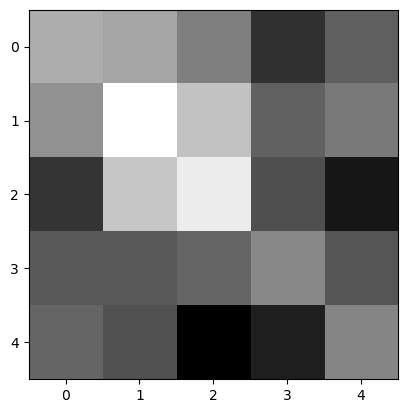

In [19]:
import matplotlib.pyplot as plt
import numpy as np

layer1_filter = 0

plt.imshow(np.squeeze(cnn.conv1.weight.detach().numpy()[layer1_filter,:,:,:]), cmap='gray')
plt.show()

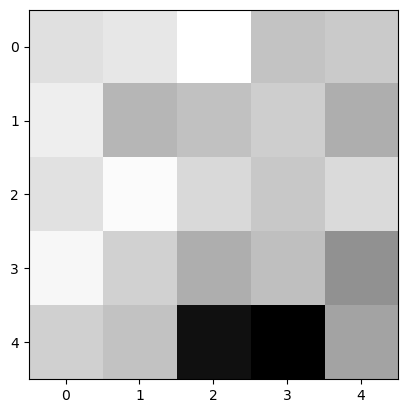

In [20]:
layer2_filter = 0

plt.imshow(cnn.conv2.weight.detach().numpy()[layer2_filter, layer1_filter, :, :], cmap='gray')
plt.show()